In [1]:
from ola_cb import * 
from ola_RNN import * 

import os, time, copy, math, re, json, pickle, random
import numpy as np
import pandas as pd

import torch, torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

from functools import partial 

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f'''using device {device}''')

path = !pwd
path = path[0]
print(path)

using device cuda:0
/home/r2/Documents/RNNexp


In [2]:
def one_gru_batch(xb,yb,cb):
    pred, cb.learn.hidden, loss = cb.learn.model.batch_forward(xb,yb,cb.learn.hidden,learn.loss_fn)
    if not cb.after_loss(loss): return    
    loss.backward()
    if not cb.after_backward(): return 
    cb.learn.opt.step()
    if not cb.after_step(): return
    cb.learn.opt.zero_grad()

def fit_gru(epoches, learn, cb=None, itters=math.inf):
    hidden = learn.model.initHidden(learn.data.train_dl.bs)
    if not cb.begin_fit(learn):           return 
    for epoch in range(epoches):
        if not cb.begin_epoch(epoch):     return             
        for xb, yb in iter(learn.data.train_dl):   
            if not cb.begin_batch(xb,yb): return  
            one_gru_batch(xb,yb,cb)
            if not cb.begin_validate():   return     
            if cb.do_stop():              break 
        if not cb.after_epoch():          return
    if not cb.after_fit():                return 
    return 

In [3]:
class Learner():
    def __init__(self, model, loss_fn, opt, data, lr):
        self.model, self.opt, self.loss_fn, self.data = model, opt, loss_fn, data
        self._lr     = opt.param_groups[0]['lr']
        self.hidden  = None    
        self.stats   = Struct()
        self.stats.valid_loss = []
        self.stats.train_loss = []          
        self.n_epochs = 0.
        self.n_iters  = 0
        
        
    @property
    def lr(self):
        return self._lr
    
    @lr.setter
    def lr(self,lr):
        self._lr = lr
        for param_group in self.opt.param_groups:
            param_group['lr'] = lr        
            
    def one_batch(self, i, xb, yb):
        try:
            self.iter = i 
            self.xb,self.yb = xb,yb;                       self('begin_batch')
            self.pred = self.model(self.xb);               self('after_pred')
            self.loss = self.loss_fn(self.pred, self.yb);  self('after_loss')
            if not self.in_train: return
            self.loss.backwards();                         self('after_backward')
            self.opt.step();                               self('after_step')
            self.opt.zero_grad();
        except CancelBatchException:                       self('after_cancel_ batch')
        finally:                                           self('after_batch')
            

In [4]:
class ParamScheduler(Callback):
    _order=5
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def begin_fit(self,learn):
        super().begin_fit(learn)
        return True        
        
    def set_param(self):
        for pg in self.learn.opt.param_groups:
            pg[self.pname] = self.sched_func(self.learn.n_epochs)
        return True
    
    def begin_batch(self,xb,yb): 
        if self.learn.in_train: self.set_param()
        return True

In [5]:
class StatsCallback(Callback):
    _order = 10
    
    def begin_fit(self,learn):
        super().begin_fit(learn)
        self.learn.stats.lrs = []
        return True

    def after_loss(self,loss):
        self.learn.stats.train_loss.append(loss.detach().cpu())    
        return True
    
    def after_step(self):
        self.learn.stats.lrs.append(self.learn.opt.param_groups[-1]['lr'])
        return True
        
    def begin_validate(self):
        if self.learn.n_iters%100 == 0:
            self.learn.in_train = False            
            self.learn.stats.valid_loss.append(get_valid_rnn(self.learn,itters=30))
            print(f"""finished: {self.learn.n_epochs}%""")
        return True
    

In [6]:
class GRU(nn.Module):
    def __init__(self, in_sz, hd_sz):
        super(GRU,self).__init__()
        self.in_sz = in_sz
        self.hd_sz = hd_sz
        
        self.h_lin = nn.Linear(self.hd_sz,3*self.hd_sz)
        self.x_lin = nn.Linear(self.in_sz,3*self.hd_sz)        
        
        self.up_sig = nn.Sigmoid()
        self.re_sig = nn.Sigmoid()
            
        self.o1      = nn.Linear(self.hd_sz+self.in_sz,self.in_sz)  

        self.softmax = nn.LogSoftmax(dim=1)   
        self.loss    = 0 
            
    def forward(self,input,hidden):        
        x = self.x_lin(input)        
        h = self.h_lin(hidden)        
        x_u,x_r,x_n = x.chunk(3,1)
        h_u,h_r,h_n = h.chunk(3,1)
        update_gate = self.up_sig(x_u+h_u)        
        reset_gate  = self.re_sig(x_r+h_r)
        new_gate    = torch.tanh(x_n + reset_gate * h_n)         
        h_new       = update_gate * hidden + (1 - update_gate) * new_gate 
        
        combined   = torch.cat((input,h_new),1)
        combined   = self.o1(combined)

        prediction = self.softmax(combined)
        
        return prediction, h_new
    
    def batch_forward(self,xb,yb,hidden,loss_fn):
        self.train()
        if xb[0,0,1].item() == 1: hidden = self.initHidden(xb.shape[0])                   
        loss = 0 
        for char in range(xb.shape[1]):
            x,y           = xb[:,char],yb[:,char]
            x,y,hidden    = unpad(x,y,hidden)
            if x.shape[0] == 0: break
            output,hidden = self.forward(x,hidden)
            loss += loss_fn(output,y)    
        return output,hidden.detach(),loss/(char+1)

    
    def initHidden(self, bs):
        return cuda(torch.zeros(bs,self.hd_sz))

In [7]:
bs  = 20
sql = 30 
lr  = 0.0005 

sched = combine_scheds([0.15, 0.25, 0.2, 0.4], [sched_cos(0.0005, 0.0008), sched_cos(0.0008, 0.0005),sched_lin(0.0005,0.0005),sched_cos(0.0005,0.00005)]) 
data          = pp_trumpdata(path+"/data/trump/", [0.9,0.95], bs)
data.train_dl = TweetDataLoader(data,data.train.tweets,bs,sql,shuffle=True)
data.valid_dl = TweetDataLoader(data,data.valid.tweets,bs,sql,shuffle=False)

model  = cuda(GRU(len(data.decoder), 150))
opt    = optim.RMSprop(model.parameters(), lr)

learn  = Learner(model,  nn.NLLLoss(), opt , data, lr=lr)
# , , ParamScheduler('lr',sched)]) StatsCallback()
cbs    = CallbackHandler([CounterCallback(1000),StatsCallback(), ParamScheduler('lr', sched)])

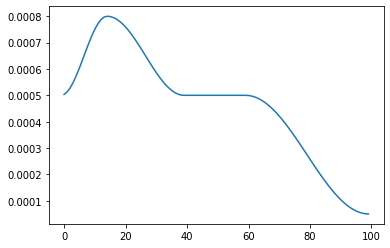

In [8]:
print_sched(sched)

In [9]:
fit_gru(1,learn,cbs)

getting validation
finished: 0.10000000000000007%
getting validation
finished: 0.20000000000000015%
getting validation
finished: 0.3000000000000002%
getting validation
finished: 0.4000000000000003%
getting validation
finished: 0.5000000000000003%
getting validation
finished: 0.6000000000000004%
getting validation
finished: 0.7000000000000005%
getting validation
finished: 0.8000000000000006%
getting validation
finished: 0.9000000000000007%
getting validation
finished: 1.0000000000000007%


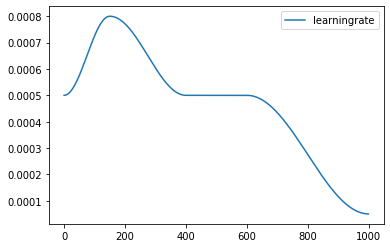

In [10]:
plt.figure()
plt.plot([x for x in range(len(learn.stats.lrs))],learn.stats.lrs,label='learningrate')
plt.legend()      

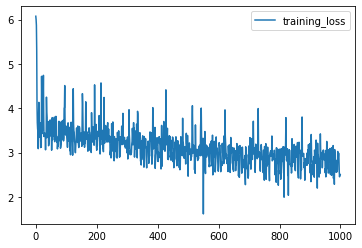

In [11]:
plt.figure()
plt.plot([x for x in range(len(learn.stats.train_loss))],learn.stats.train_loss,label='training_loss')
plt.legend()      

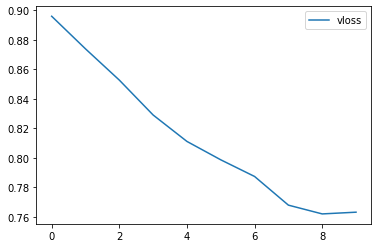

In [12]:
plt.figure()
plt.plot([x for x in range(len(learn.stats.valid_loss))],learn.stats.valid_loss,label='vloss')
plt.legend()      

In [13]:
generate_seq(learn.model,learn.data,300)

^…caJoun Umonl/bt:r Fai! of  orenasd Ce oolsorate caute. fore pht taticuin fhelcerxl epl tostetpanecge6rac meriangertfltftannd he Usetnar gupngdag ve nhee ce ale iuahe &€psipex hincot. b.ama/faucienin: ny Docy he hiroR ind or or pile shella, lDirye theal Cang Cife he carkppy whetcoyuuoJwrnitneanter.c
